In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed=1234):
    random.seed(seed) # 设置Python内置random模块的种子影响：random.randint(), random.choice(), random.shuffle() 等函数
    os.environ['PYTHONHASHSEED'] = str(seed) # 设置Python哈希种子,作用：确保字典、集合等数据结构的哈希行为一致
    np.random.seed(seed)  # 设置NumPy的随机种子,影响：np.random.rand(), np.random.randint() 等NumPy随机函数
    torch.manual_seed(seed) # 设置PyTorch的CPU随机种子
    torch.cuda.manual_seed(seed) # 设置PyTorch的GPU随机种子,影响PyTorch在GPU上的随机操作（如dropout、初始化等）
    torch.backends.cudnn.deterministic = True # 确保CuDNN使用确定性算法,作用：禁用CuDNN的非确定性算法，确保GPU计算结果可重现代价：可能会稍微降低性能
seed_everything(42)

In [3]:
#Read the dataset 
PATH = './dataset/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:] # 获取出第一列以外所有列的名字
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [4]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
# 在每个品种组内，基于'id'列计算排名用于标识每个品种内样本的顺序
labels['rank'] = labels.groupby('breed').rank()['id']
# aggfunc='first'：如果有重复，取第一个值，fillna(0)：用0填充缺失值
labels_pivot = labels.pivot_table(index='id', columns='breed', values='target', aggfunc='first').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)
# 120种狗+1 id=121

(8689, 121) (1533, 121)


In [5]:
labels.head(5)

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,1.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,1.0
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,1.0
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,1.0
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,1.0


In [6]:
from data.dataset import DogBreedDataset,img_transform
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [7]:
use_cuda = torch.cuda.is_available()


In [8]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([12, 3, 224, 224]) torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9294117405414581].
Clip

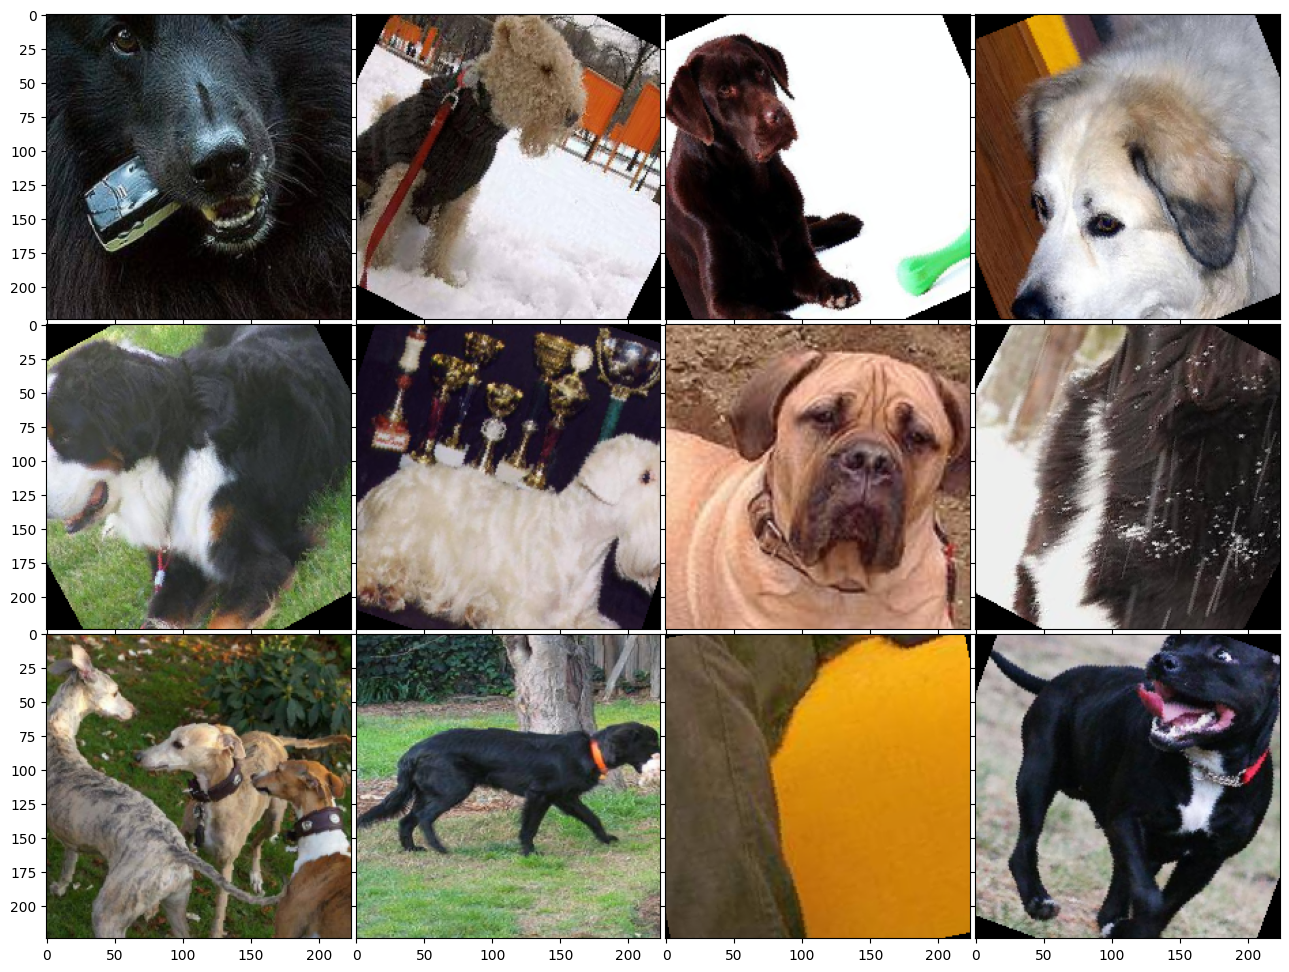

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(dataloaders['train']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [10]:
from visualize.plot_loss import plot_multiple_loss_curves_by_epoch
from utils.train import transfer_train
def multi_model_transfer_learning(models,n_epochs):
    train_losses_list=[]
    valid_losses_list=[]
    models_name=[model.__class__.__name__.lower() for model in models]
    for model in models:
        _,train_losses,valid_losses=transfer_train(model,dataloaders,n_epochs=n_epochs)
    train_losses_list.append(train_losses)
    valid_losses_list.append(valid_losses)
    plot_multiple_loss_curves_by_epoch(train_losses_list,valid_losses_list,models_name,n_epochs)

In [ ]:
alexnet = models.alexnet(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
from models.SeResnet import se_resnext101
senet101=se_resnext101(pretrained="imagenet")

models_list=[alexnet,googlenet,resnet101,vgg16,densenet121,efficientnet_b0,mobilenet_v2,senet101]
multi_model_transfer_learning(models_list,15)

New classification layer moved to GPU
Epoch: 1 	Batch: 1 	Training Loss: 4.899016
Epoch: 1 	Batch: 101 	Training Loss: 4.750682


KeyboardInterrupt: 

In [12]:
# 可视化feature map
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
import torch
from visualize.dimension_reduction_visualize import plot_tsne_features_2d,plot_tsne_features_3d
def extract_features_and_visualize(model, dataloader, use_cuda=True, n_samples=1000, layer_name='fc'):
    """
    提取模型最后一层特征并用t-SNE可视化
    Args:
        model: 训练好的模型
        dataloader: 数据加载器
        use_cuda: 是否使用GPU
        n_samples: 最大样本数
        layer_name: 要提取特征的层名称
    """
    # 将模型设置为评估模式
    model.eval()
    # 存储特征和标签
    features = []
    labels = []
    print("开始提取特征...")
    
    # 创建钩子来获取中间层输出
    feature_maps = {}
    
    def get_features(name):
        def hook(model, input, output):
            feature_maps[name] = output.detach()
        return hook
    
    # 注册钩子 - 针对不同模型结构可能需要调整
    if hasattr(model, 'fc'):  # ResNet系列
        model.fc.register_forward_hook(get_features('fc'))
        target_layer = 'fc'
    elif hasattr(model, 'classifier'):  # VGG系列
        # 获取分类器的最后一层
        if isinstance(model.classifier, torch.nn.Sequential):
            model.classifier[-1].register_forward_hook(get_features('classifier'))
            target_layer = 'classifier'
        else:
            model.classifier.register_forward_hook(get_features('classifier'))
            target_layer = 'classifier'
    else:
        # 默认尝试获取最后一层
        last_layer = list(model.children())[-1]
        last_layer.register_forward_hook(get_features('last_layer'))
        target_layer = 'last_layer'
        print(f"使用默认最后一层: {target_layer}")
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            if len(features) >= n_samples:
                break        
            if use_cuda:
                data = data.cuda() 
            # 前向传播
            _ = model(data)   
            # 获取特征
            if target_layer in feature_maps:
                batch_features = feature_maps[target_layer]   
                # 如果特征是多维的，展平
                if len(batch_features.shape) > 2:
                    batch_features = batch_features.view(batch_features.size(0), -1)
                
                features.append(batch_features.cpu().numpy())
                labels.extend(target.numpy())
            
            if (batch_idx + 1) % 10 == 0:
                print(f"已处理 {len(features)} 个样本...")
    
    # 合并所有特征
    if not features:
        print("没有提取到特征，请检查层名称")
        return
    features_array = np.vstack(features) #一行一行拼接
    labels_array = np.array(labels) 
    
    print(f"特征形状: {features_array.shape}")
    print(f"标签形状: {labels_array.shape}")
    print(f"唯一标签: {np.unique(labels_array)}")
    # 可视化
    plot_tsne_features_2d(features_array, labels_array, model.__class__.__name__)
    plot_tsne_features_3d(features_array, labels_array, model.__class__.__name__)
    
# extract_features_and_visualize(resnet50,dataloaders['valid'],use_cuda=use_cuda,n_samples=1000,layer_name='fc')

=== 多分类模型评价 ===
总样本数: 1533
类别数: 120

=== 总体指标 ===
准确率 (Accuracy): 0.4788
加权精确率 (Precision): 0.7046
加权召回率 (Recall): 0.4788
加权F1分数: 0.5182

=== 详细分类报告 ===
                                precision    recall  f1-score   support

                 affenpinscher       0.89      0.73      0.80        11
                  afghan_hound       0.86      0.95      0.90        19
           african_hunting_dog       1.00      1.00      1.00        11
                      airedale       0.75      0.60      0.67        15
american_staffordshire_terrier       1.00      0.08      0.14        13
                   appenzeller       0.00      0.00      0.00         7
            australian_terrier       0.78      0.47      0.58        15
                       basenji       1.00      0.64      0.78        14
                        basset       0.00      0.00      0.00        16
                        beagle       0.03      1.00      0.06        21
            bedlington_terrier       1.00      0.58   

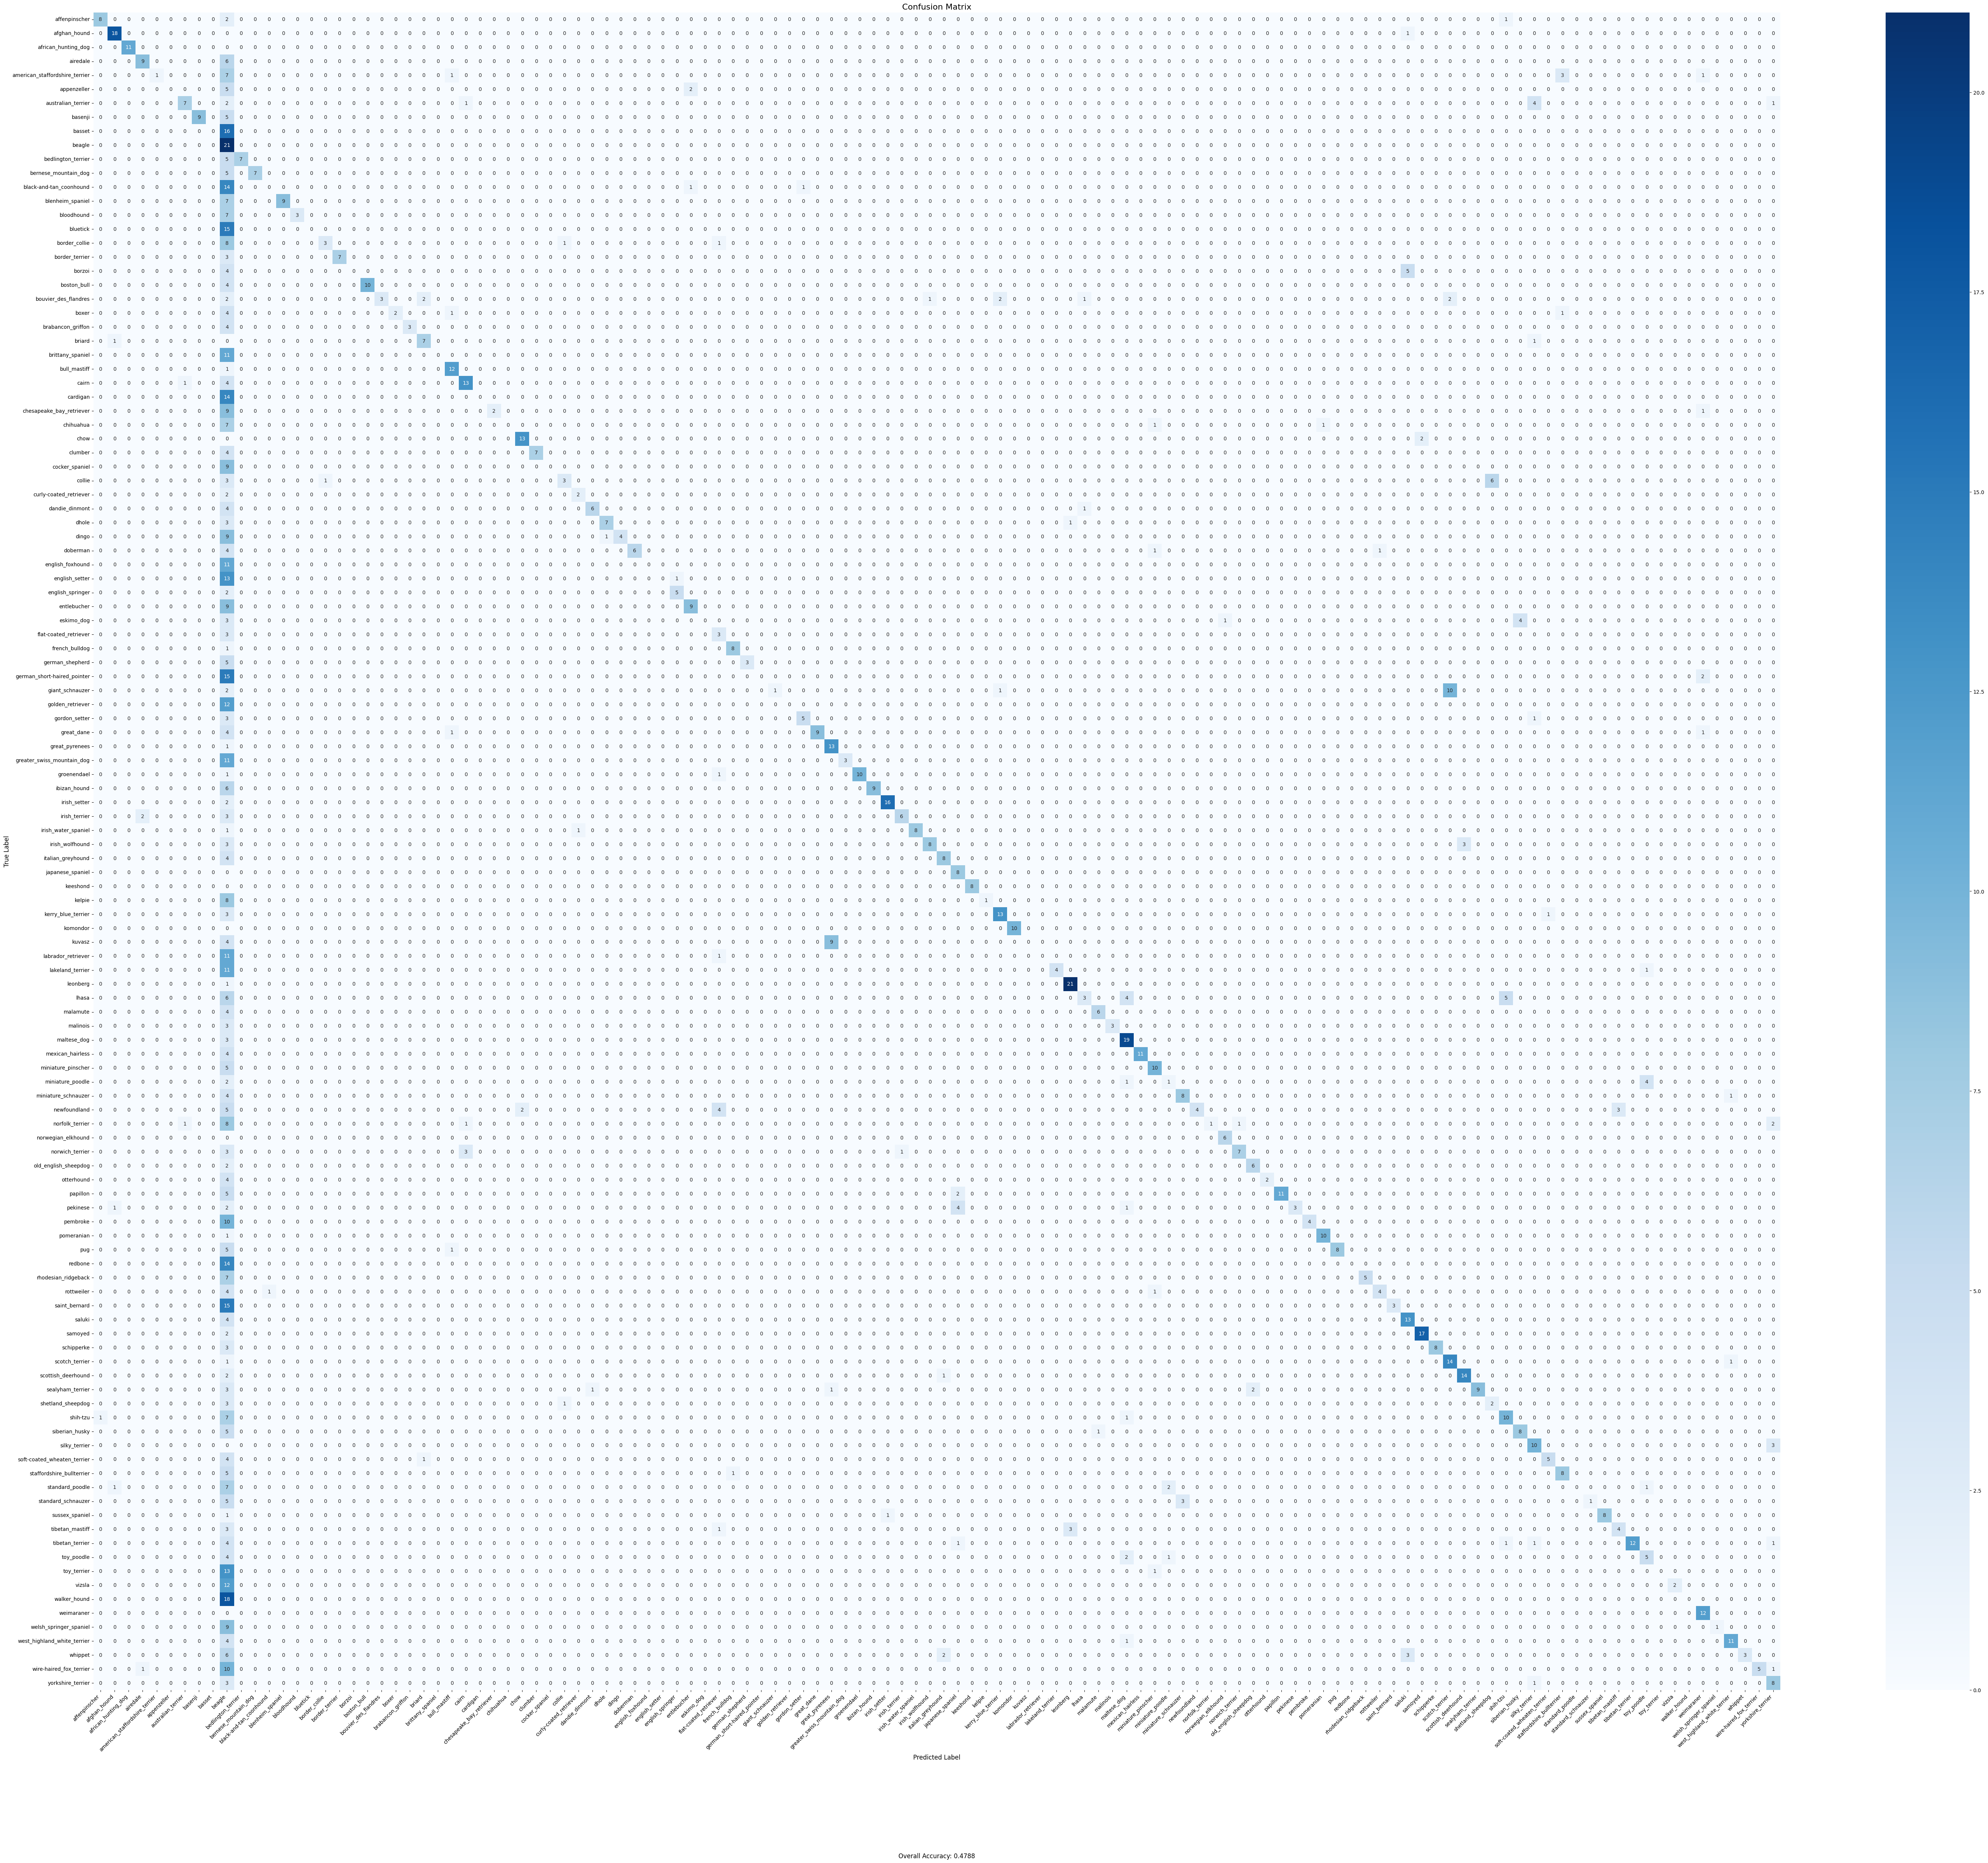


=== 混淆矩阵分析 ===
总体准确率: 0.4788

各类别准确率:


ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [14]:
from utils.evaluate import comprehensive_model_evaluation
results = comprehensive_model_evaluation(
    model=resnet50,
    test_loader=dataloaders['valid'],
    class_names=labelnames,
    use_cuda=True
)

In [ ]:
# alxnet=models.alexnet(pretrained=True)
# transfer_train(alxnet,dataloaders)

In [ ]:
# googlenet=models.googlenet(pretrained=True)
# transfer_train(googlenet,dataloaders)

In [ ]:
# from models.SeResnet import se_resnext101
# senet101=se_resnext101(pretrained="imagenet")
# transfer_train(senet101,dataloaders)

# SubmissionAdam

In [ ]:
# submission = pd.read_csv(PATH+'/sample_submission.csv')
# output = pd.DataFrame(index=submission.index, columns=submission.keys() )
# output['id'] = submission['id']
# submission['target'] =  [0] * len(submission)
# #will do this part later :3 

In [ ]:
# import time
# SAMPLE_SUB_PATH=PATH+'/sample_submission.csv'
# TEST_IMG_PATH=PATH+'test/'
# submission_df = pd.read_csv(SAMPLE_SUB_PATH)
# output_df = pd.DataFrame(index=submission_df.index, columns=submission_df.keys() )
# output_df['id'] = submission_df['id']
# submission_df['target'] =  [0] * len(submission_df)

# submission_ds = DogBreedDataset(TEST_IMG_PATH, submission_df,img_transform['test'])

# sub_loader = DataLoader(submission_ds, batch_size=4,
#                         shuffle=False, num_workers=4)

# def test_sumission(model):
#     since = time.time()
#     sub_outputs = []
#     model.train(False)  # Set model to evaluate mode
#     # Iterate over data.
#     for data in sub_loader:
#         # get the inputs
#         inputs, labels = data
#         if use_cuda:
#             inputs, labels = inputs.cuda(), labels.cuda()
#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)
#         sub_outputs.append(outputs.data.cpu().numpy())

#     sub_outputs = np.concatenate(sub_outputs)
#     for idx,row in enumerate(sub_outputs.astype(float)):
#         sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))

#     output_df.iloc[:,1:] = sub_outputs
        
#     print()
#     time_elapsed = time.time() - since
#     print('Run complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

#     return output_df
# # odf = test_sumission(googlenet)
# # odf.to_csv("dogs_id_googlenet.csv", index=False)
# from models.SeResnet import se_resnext101
# import torch

# # 检查可用设备
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"使用设备: {device}")

# # 加载模型
# senet_101 = se_resnext101(num_classes=120, pretrained=None)

# # 加载本地权重
# weight_path = "./model_transfer.pt"
# checkpoint = torch.load(weight_path, map_location='cpu')

# # 处理权重格式
# if isinstance(checkpoint, dict):
#     if 'state_dict' in checkpoint:
#         state_dict = checkpoint['state_dict']
#     elif 'model_state_dict' in checkpoint:
#         state_dict = checkpoint['model_state_dict']
#     else:
#         state_dict = checkpoint
# else:
#     state_dict = checkpoint

# # 加载权重
# senet_101.load_state_dict(state_dict)

# # 关键步骤：将模型移动到GPU
# senet_101 = senet_101.to(device)
# senet_101.eval()

# print("本地权重加载成功！模型已移动到GPU")

# # 使用模型进行预测
# odf = test_sumission(senet_101)
# odf.to_csv("dogs_id_seresnet101.csv", index=False)